# Variational Autoencoder (VAE) on MNIST

A VAE extends a standard autoencoder by introducing a **stochastic latent space**:

- Encoder predicts **mean and variance** for each latent dimension
- Sampling introduces variability
- Decoder reconstructs from sampled latent vectors

This allows:

- Generating new digits
- Exploring latent space
- Smooth interpolation between digits


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


In [8]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images to [-1, 1] for VAE
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


In [9]:
# VAE Model

latent_dim = 2  # for easy 2D visualization

inputs = layers.Input(shape=(28,28,1))
x = layers.Conv2D(32,3,activation='relu',padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(decoder_input)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64,3,strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(32,3,strides=2,activation='relu',padding='same')(x)
decoder_output = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(decoder_input, decoder_output)
outputs = decoder(z)

vae = Model(inputs, outputs)

# VAE loss
reconstruction_loss = tf.keras.losses.mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28*28
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 64)   18496       ['max_pooling2d_2[0][0]']        
                                                                                            

In [10]:
# Train VAE

vae.fit(x_train, epochs=5, batch_size=64, validation_data=(x_test,None))


Epoch 1/5
938/938 [==============================] - 94s 99ms/step - loss: 739.1256 - val_loss: 725.8283
Epoch 2/5
938/938 [==============================] - 96s 102ms/step - loss: 725.4904 - val_loss: 725.8274
Epoch 3/5
938/938 [==============================] - 94s 101ms/step - loss: 725.4885 - val_loss: 725.8272
Epoch 4/5
938/938 [==============================] - 91s 98ms/step - loss: 725.4899 - val_loss: 725.8270
Epoch 5/5
938/938 [==============================] - 89s 95ms/step - loss: 725.4899 - val_loss: 725.8270


313/313 [==============================] - 1s 2ms/step


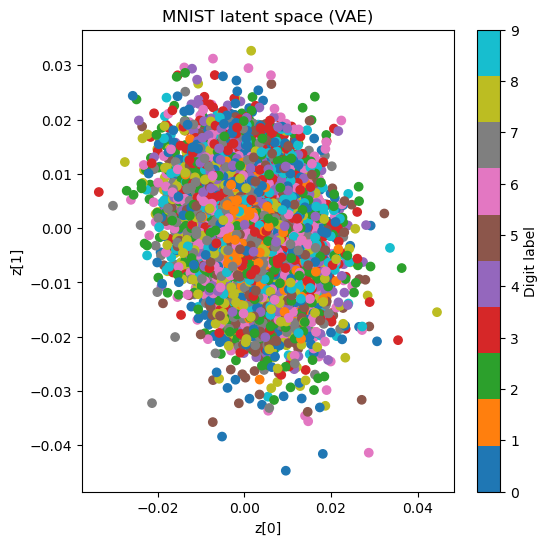

In [14]:
# Visualize Latent Space

import matplotlib.cm as cm

encoder = tf.keras.Model(inputs, z_mean)  
z_test = encoder.predict(x_test)

plt.figure(figsize=(6,6))
plt.scatter(z_test[:,0], z_test[:,1], c=y_test, cmap=cm.tab10)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("MNIST latent space (VAE)")
plt.colorbar(label='Digit label')
plt.show()
